In [53]:
%load_ext autoreload
%autoreload 2

from rcwa import Source, Layer, LayerStack, Crystal, Solver, RectangularGrating
from rcwa.shorthand import complexArray
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
reflection_layer = Layer(er=1.0, ur=1.0)
transmission_layer = Layer(er=5.00237**2, ur=1.0)

wavelength = 0.5
deg = np.pi / 180
k0 = 2*np.pi/wavelength
theta = -45 * deg
phi = 0 * deg
# pTEM = 1/np.sqrt(2)*complexArray([1,1j])
pTEM = complexArray([1, 0]) #TE = 100%, y-component only, 
source = Source(wavelength=wavelength, theta=theta, phi=phi, pTEM=pTEM, layer=reflection_layer)

print(f"X amplitude of source = {source.pX}")
print(f"Y amplitude of source = {source.pY}")

X amplitude of source = (-0+0j)
Y amplitude of source = (-1+0j)


In [55]:
crystal_thickness = 0.5

N_harmonics = 81

period = 0.5

F = 0.05
f0 = 0.016
Nx = 50000

air_layer = Layer(er=1.0, ur=1.0, thickness=0.35)
grating_layer_top = RectangularGrating(period=period, thickness=0.15, er=1.497**2, er_void=1.0, ur=1.0, ur_void=1.0, nx=Nx, groove_width=0.25, offset=0.0)
oxide_sandwich_layer = Layer(er=1.46766**2, ur=1.0, thickness=0.05)
substrate_layer = Layer(er=5.00237**2, ur=1.0, thickness=0.7)

intentional_offset_arr = np.array([F + f0, -F + f0, F - f0, -F - f0])
offset_arr = np.arange(-5, 6)/500
      
tot_off = 0.066

grating_layer_bottom = RectangularGrating(period=period, thickness=0.15, er=5.00237**2, er_void=1.46766**2, ur=1.0, ur_void=1.0, nx=Nx, offset=tot_off, groove_width=0.25)
layer_stack = LayerStack(air_layer, grating_layer_top, oxide_sandwich_layer, grating_layer_bottom, substrate_layer, incident_layer=reflection_layer, transmission_layer=transmission_layer)

solver_1d = Solver(layer_stack, source, N_harmonics)
results = solver_1d.solve()

KeyboardInterrupt: 

In [22]:
grating_layer_top._er_data()[0].shape

(500,)

# Plotting the Geometry

In [25]:
plt.figure()
er_matrix_global, ur_matrix_global = layer_stack.er_ur_geometry(Nx)
plt.imshow(er_matrix_global, 
           aspect=1, 
           extent=(0, period, layer_stack.total_thickness, 0), 
           cmap=plt.get_cmap("YlGn"), 
           norm="log")
plt.xlabel("x (um)")
plt.ylabel("z (um)")
plt.title(r"$\varepsilon_r$")
plt.colorbar()

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

# Run algorithm defined in Lumerical example

In [26]:
x_order = np.arange(-40, 41)

In [27]:
_, reflectedEy, _ = solver_1d.reflectedElectricComponents_1D()

In [74]:
np.square(np.abs((reflectedEy)))[39:41]

array([0.18802715, 0.06189409])

(-3.0, 3.0)

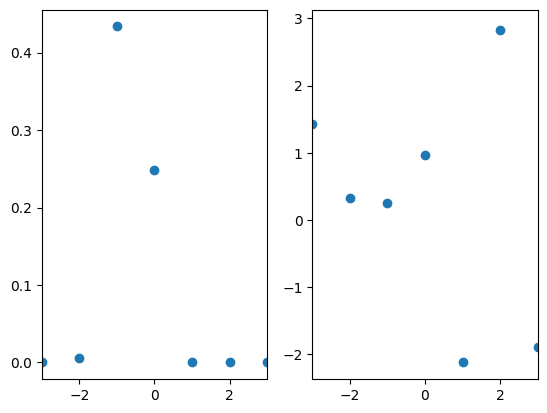

In [30]:
plt.figure()
plt.subplot(121)
plt.scatter(x_order, np.abs((reflectedEy)))
plt.xlim([-3, 3])
plt.subplot(122)
plt.scatter(x_order, np.angle((reflectedEy)))
plt.xlim([-3, 3])

(-3.0, 3.0)

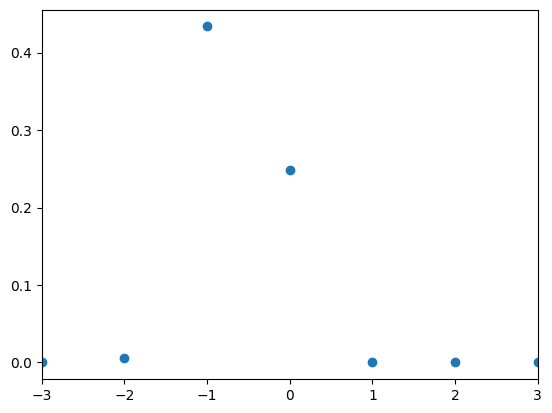

In [29]:
plt.scatter(x_order, np.abs(reflectedEy))
plt.xlim([-3, 3])

In [8]:
filename = './20250929_LumericalOffset0066/20250929_Offset0066_eky_fs_Re.txt'

# Read the file, skipping the first line
with open(filename, 'r') as f:
    lines = f.readlines()[1:]  # Skip first line

# Convert lines to a 2D numpy array (assuming whitespace-separated values)
eky_fs_Re = np.array([list(map(float, line.split())) for line in lines])

In [10]:
filename = './20250929_LumericalOffset0066/20250929_Offset0066_eky_fs_Im.txt'

# Read the file, skipping the first line
with open(filename, 'r') as f:
    lines = f.readlines()[1:]  # Skip first line

# Convert lines to a 2D numpy array (assuming whitespace-separated values)
eky_fs_Im = np.array([list(map(float, line.split())) for line in lines])

In [9]:
eky_fs_Re[38:43]

array([[-1.87863511e-02],
       [-3.76090872e-01],
       [ 4.62215895e-02],
       [ 7.62346919e-03],
       [ 3.09151140e-05]])

In [11]:
eky_fs_Im[38:43]

array([[ 3.54706383e-02],
       [ 2.44871135e-01],
       [-2.44643987e-01],
       [ 3.09178510e-03],
       [-7.09640355e-05]])

In [12]:
eky_fs_Abs = np.sqrt(np.square(eky_fs_Re) + np.square(eky_fs_Im))

In [34]:
eky_fs_phase = np.atan(eky_fs_Re/eky_fs_Im)

Text(0, 0.5, 'E-field phase')

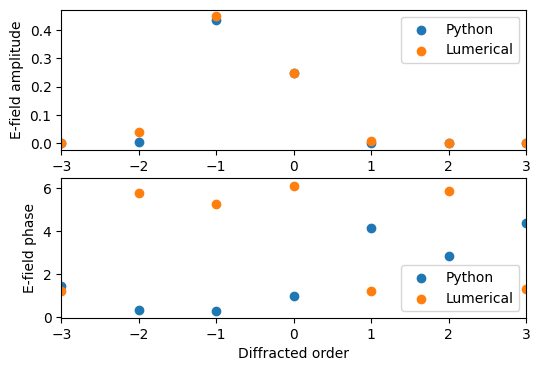

In [60]:
plt.figure(figsize=(6, 4))
plt.subplot(211)
plt.scatter(x_order, np.abs(reflectedEy), label="Python")
plt.scatter(x_order, eky_fs_Abs, label="Lumerical")
plt.xlim([-3, 3])
plt.legend()
plt.xlabel("Diffracted order")
plt.ylabel("E-field amplitude")
plt.subplot(212)
plt.scatter(x_order, np.angle(reflectedEy) % (2*np.pi), label="Python")
plt.scatter(x_order, eky_fs_phase % (2*np.pi), label="Lumerical")
plt.xlim([-3, 3])
plt.legend()
plt.xlabel("Diffracted order")
plt.ylabel("E-field phase")

In [62]:
eky_fs_Abs.shape

(81, 1)

Text(0, 0.5, 'E-field phase')

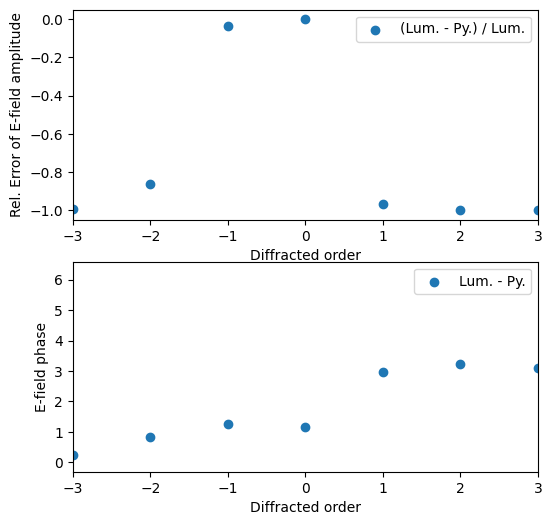

In [70]:
plt.figure(figsize=(6, 6))
plt.subplot(211)
plt.scatter(x_order, (np.abs(reflectedEy) - eky_fs_Abs.squeeze())/eky_fs_Abs.squeeze(), label="(Lum. - Py.) / Lum.")
plt.xlim([-3, 3])
plt.legend()
plt.xlabel("Diffracted order")
plt.ylabel("Rel. Error of E-field amplitude")
plt.subplot(212)
plt.scatter(x_order, (np.angle(reflectedEy) - eky_fs_phase.squeeze()) % (2*np.pi), label="Lum. - Py.")
plt.xlim([-3, 3])
plt.legend()
plt.xlabel("Diffracted order")
plt.ylabel("E-field phase")

In [50]:
np.sum((np.angle(reflectedEy) - eky_fs_phase.squeeze()) % (2*np.pi))

np.float64(214.71511225411226)

In [51]:
np.sum(np.minimum(
    (np.angle(reflectedEy) - eky_fs_phase.squeeze()) % (2*np.pi),
    (eky_fs_phase.squeeze() - np.angle(reflectedEy)) % (2*np.pi)))

np.float64(155.58122075744663)

In [42]:
np.abs(reflectedEy).shape

(81,)

In [45]:
eky_fs_phase.shape

(81, 1)

In [ ]:
np.angle(reflectedEy) - eky_fs_phase.squeeze()

(-3.0, 3.0)

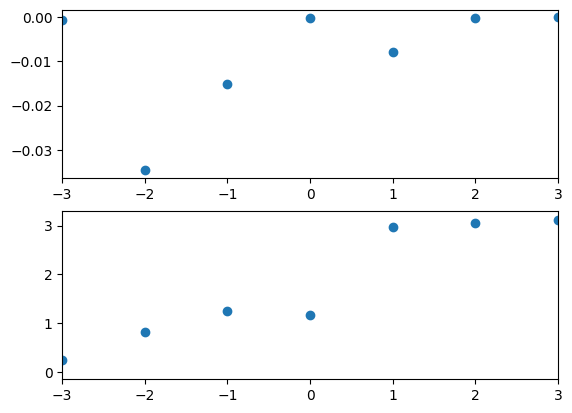

In [52]:
plt.figure()
plt.subplot(211)
plt.scatter(x_order, np.abs(reflectedEy) - eky_fs_Abs.squeeze())
plt.xlim([-3, 3])
plt.subplot(212)
plt.scatter(x_order, np.minimum(
    (np.angle(reflectedEy) - eky_fs_phase.squeeze()) % (2*np.pi),
    (eky_fs_phase.squeeze() - np.angle(reflectedEy)) % (2*np.pi)))
plt.xlim([-3, 3])

In [19]:
eky_fs_Abs.sum()

np.float64(0.7467508198707347)

In [ ]:
np.real(reflectedEy)[38:43] # Order 39th to 43th

array([5.23521331e-03, 4.39827465e-01, 3.60368132e-01, 2.73220086e-04,
       1.36366852e-07])

In [36]:
np.imag(reflectedEy)[38:43] # Order 39th to 43th

array([ 2.11448935e-03,  9.38905043e-02,  2.68457453e-01, -2.16086201e-04,
        5.13838584e-08])

In [18]:
np.abs(reflectedEy).sum()

np.float64(0.805927619031062)

# Comparing with Lumerical RCWA



In [20]:
filename = './20250929_LumericalOffset0066/20250929_Offset0066_Rs.txt'

# Read the file, skipping the first line
with open(filename, 'r') as f:
    lines = f.readlines()[1:]  # Skip first line

# Convert lines to a 2D numpy array (assuming whitespace-separated values)
Rs = np.array([list(map(float, line.split())) for line in lines])

(-3.0, 3.0)

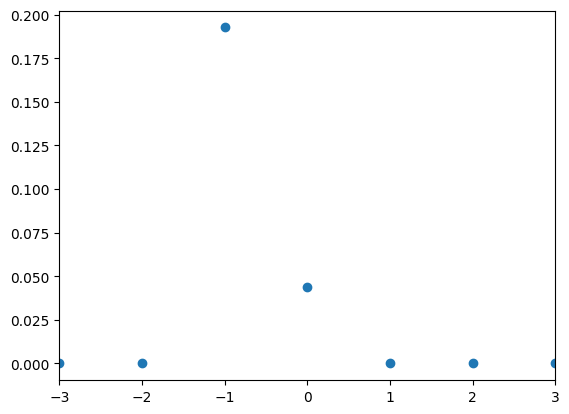

In [22]:
plt.scatter(x_order, Rs)
plt.xlim([-3, 3])

In [53]:
RPower = results["ry"]

(-3.0, 3.0)

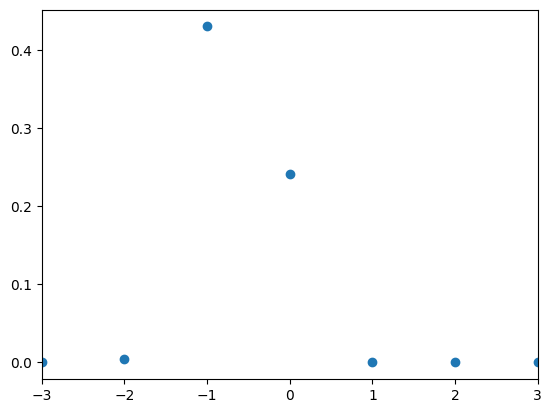

In [54]:
plt.scatter(x_order, RPower)
plt.xlim([-3, 3])

In [37]:
diffracted_power = np.array([
    1.32E-8,
    2.27E-8,
    1.07E-8,
    5.15E-9,
    1.97E-7,
    6.75E-8,
    2.31E-9,
    1.34E-8,
    5.98E-9
])

In [39]:
diffracted_power*(0.2419/0.394/5E-7)

array([0.01620853, 0.02787376, 0.01313873, 0.00632378, 0.2419    ,
       0.08288452, 0.00283649, 0.01645411, 0.00734295])

In [40]:
diffracted_power/5E-7

array([0.0264 , 0.0454 , 0.0214 , 0.0103 , 0.394  , 0.135  , 0.00462,
       0.0268 , 0.01196])

# 

In [42]:
3.097484035E-8/5E-7

0.06194968070000001

In [44]:
eky_fs = 0.0462216-0.244644j

In [45]:
np.square(np.abs(eky_fs))

np.float64(0.06198712304256)

In [46]:
before_ray = -5.416452E-4+4.54555265E-4j

In [47]:
before_ray*eky_fs

(8.616851047434001e-05+0.000153520519945524j)

In [49]:
after_ray = -1.0599E-4+1.40503E-4j

In [50]:
after_ray/before_ray

(0.2425507006546153-0.05584892469831851j)

In [51]:
1.2702E-7/5E-7

0.25404000000000004

In [ ]:
eps_arr = np.empty_like(offset_arr)
for i in range(len(offset_arr)):
    # S1, 2, 3, 4
    S1234 = np.empty((4,))
    for j in range(4):
        # RPower = np.square(np.abs(solver_1d.rx)) + np.square(np.abs(solver_1d.ry)) + np.square(np.abs(solver_1d.rz))
        
        RPower = np.square(np.abs(reflectedEy))
        zeroOrderIndex = solver_1d.n_harmonics // 2
        S1234[j] = RPower[zeroOrderIndex]
    # D1, 2
    D1 = S1234[0] - S1234[1] # S1 - S2
    D2 = S1234[2] - S1234[3] # S3 - S4
    eps_arr[i] = f0*(D1+D2)/(D1-D2)

In [15]:
eps_arr[5]

np.float64(-0.25747886749593635)

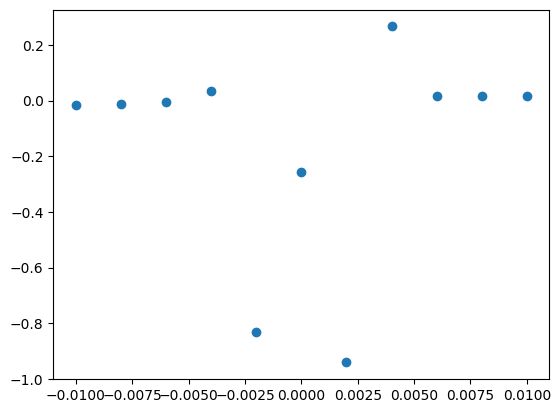

In [16]:
plt.scatter(offset_arr, eps_arr)

In [259]:
print(result_matrix[5, 0]["RTot"])
print(result_matrix[5, 1]["RTot"])
print(result_matrix[5, 2]["RTot"])
print(result_matrix[5, 3]["RTot"])

0.19912557777522896
0.19912551044508953
0.1991210161295596
0.19912557777440762


In [260]:
kx_normalized/k0

array([ 40.05626977+0.j,  39.05626977+0.j,  38.05626977+0.j,
        37.05626977+0.j,  36.05626977+0.j,  35.05626977+0.j,
        34.05626977+0.j,  33.05626977+0.j,  32.05626977+0.j,
        31.05626977+0.j,  30.05626977+0.j,  29.05626977+0.j,
        28.05626977+0.j,  27.05626977+0.j,  26.05626977+0.j,
        25.05626977+0.j,  24.05626977+0.j,  23.05626977+0.j,
        22.05626977+0.j,  21.05626977+0.j,  20.05626977+0.j,
        19.05626977+0.j,  18.05626977+0.j,  17.05626977+0.j,
        16.05626977+0.j,  15.05626977+0.j,  14.05626977+0.j,
        13.05626977+0.j,  12.05626977+0.j,  11.05626977+0.j,
        10.05626977+0.j,   9.05626977+0.j,   8.05626977+0.j,
         7.05626977+0.j,   6.05626977+0.j,   5.05626977+0.j,
         4.05626977+0.j,   3.05626977+0.j,   2.05626977+0.j,
         1.05626977+0.j,   0.05626977+0.j,  -0.94373023+0.j,
        -1.94373023+0.j,  -2.94373023+0.j,  -3.94373023+0.j,
        -4.94373023+0.j,  -5.94373023+0.j,  -6.94373023+0.j,
        -7.94373023+0.j,

/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'S4, eps=-0.01')

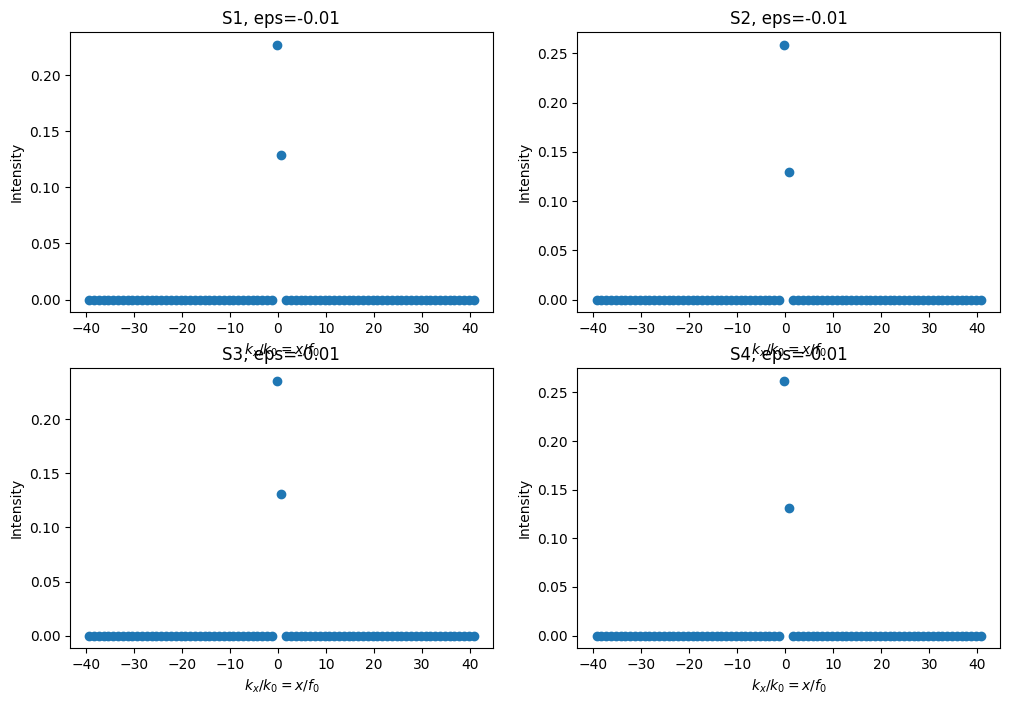

In [17]:
i = 0
plt.figure(figsize=(12, 8))
plt.subplot(221)
j = 0
solver_1d = solver_matrix[i, j]
# RPower = np.square(np.abs(solver_1d.rx)) + np.square(np.abs(solver_1d.ry)) + np.square(np.abs(solver_1d.rz))
RPower = result_matrix[i, j]["R"]
zeroOrderIndex = solver_1d.n_harmonics // 2
kx_normalized = solver_1d.kx_vector
plt.scatter(kx_normalized, RPower)
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"Intensity")
plt.title(f"S1, eps={offset_arr[i]}")
plt.subplot(222)
j = 1
solver_1d = solver_matrix[i, j]
# RPower = np.square(np.abs(solver_1d.rx)) + np.square(np.abs(solver_1d.ry)) + np.square(np.abs(solver_1d.rz))
RPower = result_matrix[i, j]["R"]
zeroOrderIndex = solver_1d.n_harmonics // 2
kx_normalized = solver_1d.kx_vector
plt.scatter(kx_normalized, RPower)
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"Intensity")
plt.title(f"S2, eps={offset_arr[i]}")
plt.subplot(223)
j = 2
solver_1d = solver_matrix[i, j]
# RPower = np.square(np.abs(solver_1d.rx)) + np.square(np.abs(solver_1d.ry)) + np.square(np.abs(solver_1d.rz))
RPower = result_matrix[i, j]["R"]
zeroOrderIndex = solver_1d.n_harmonics // 2
kx_normalized = solver_1d.kx_vector
plt.scatter(kx_normalized, RPower)
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"Intensity")
plt.title(f"S3, eps={offset_arr[i]}")
plt.subplot(224)
j = 3
solver_1d = solver_matrix[i, j]
# RPower = np.square(np.abs(solver_1d.rx)) + np.square(np.abs(solver_1d.ry)) + np.square(np.abs(solver_1d.rz))
RPower = result_matrix[i, j]["R"]
zeroOrderIndex = solver_1d.n_harmonics // 2
kx_normalized = solver_1d.kx_vector
plt.scatter(kx_normalized, RPower)
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"Intensity")
plt.title(f"S4, eps={offset_arr[i]}")

In [18]:
j = 0
solver_1d = solver_matrix[i, j]
# RPower = np.square(np.abs(solver_1d.rx)) + np.square(np.abs(solver_1d.ry)) + np.square(np.abs(solver_1d.rz))
RPower = result_matrix[i, j]["R"]
zeroOrderIndex = solver_1d.n_harmonics // 2
kx_normalized = solver_1d.kx_vector

In [19]:
RPower

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.12913062, 0.2266627 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [20]:
_, reflectedEy, _ = solver_1d.reflectedElectricComponents_1D()

In [21]:
plt.scatter(kx_normalized, reflectedEx)

NameError: name 'reflectedEx' is not defined

In [22]:
plt.scatter(kx_normalized, np.sqrt(np.square(np.abs(reflectedEx)) + np.square(np.abs(reflectedEz))))

NameError: name 'reflectedEx' is not defined

In [219]:
np.sqrt(np.square(np.abs(reflectedEx)) + np.square(np.abs(reflectedEz)))

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 4.84002465e-148, 1.49738589e-123,
       6.49597647e-100, 2.55648257e-075, 1.02150835e-051, 8.58969155e-027,
       1.78604455e-001, 4.74456971e-024, 5.03435928e-049, 1.43540354e-072,
       3.10906140e-097, 8.44466397e-121, 2.29393860e-145, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

# Let us find the linear region

In [23]:
Ry_0_matrix = np.empty((len(offset_arr), 4))

for i in range(len(offset_arr)):
    for j in range(4):
        solver_1d = solver_matrix[i, j]
        _, reflectedEy, _ = solver_1d.reflectedElectricComponents_1D()
        RPower = np.abs(reflectedEy)
        zeroOrderIndex = solver_1d.n_harmonics // 2 
        Ry_0_matrix[i, j] = RPower[zeroOrderIndex]

In [24]:
Ry_0_matrix[5]

array([0.36036813, 0.35980137, 0.36100892, 0.36036813])

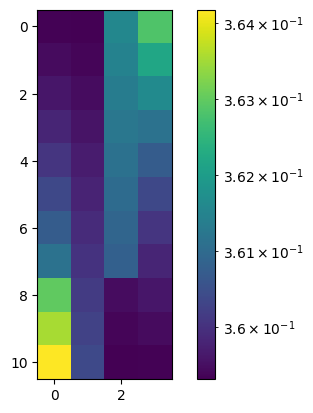

In [25]:
plt.imshow(Ry_0_matrix, norm="log")
plt.colorbar()

In [ ]:
eps_arr = np.empty_like(offset_arr)
for i in range(len(offset_arr)):
    # S1, 2, 3, 4
    S1234 = np.empty((4,))
    for j in range(4):
        solver_1d = solver_matrix[i, j]
        # RPower = np.square(np.abs(solver_1d.rx)) + np.square(np.abs(solver_1d.ry)) + np.square(np.abs(solver_1d.rz))
        _, reflectedEy, _ = solver_1d.reflectedElectricComponents_1D()
        RPower = np.square(np.abs(reflectedEy))
        zeroOrderIndex = solver_1d.n_harmonics // 2
        S1234[j] = RPower[zeroOrderIndex]
    # D1, 2
    D1 = S1234[0] - S1234[1] # S1 - S2
    D2 = S1234[2] - S1234[3] # S3 - S4
    eps_arr[i] = f0*(D1+D2)/(D1-D2)

# Plotting the Kx, Ky matrices

In [48]:
kx_normalized = solver_1d.kx_vector
ky_normalized = solver_1d.ky_vector

Text(0, 0.5, 'Im$(k_{x, m})$')

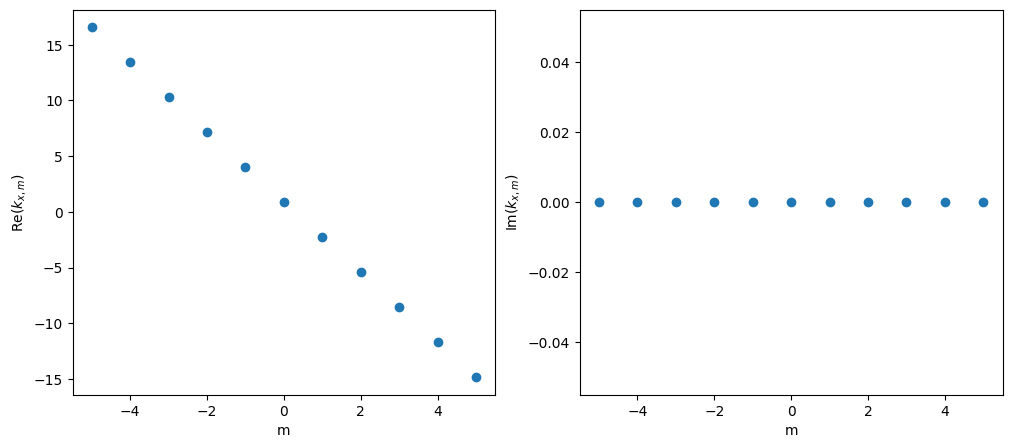

In [47]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(np.arange(-5, 6), np.real(kx_normalized))
plt.xlabel("m")
plt.ylabel(r"Re$(k_{x, m})$")
plt.subplot(122)
plt.scatter(np.arange(-5, 6), np.imag(kx_normalized))
plt.xlabel("m")
plt.ylabel(r"Im$(k_{x, m})$")

Text(0, 0.5, 'Im$(k_{y, n})$')

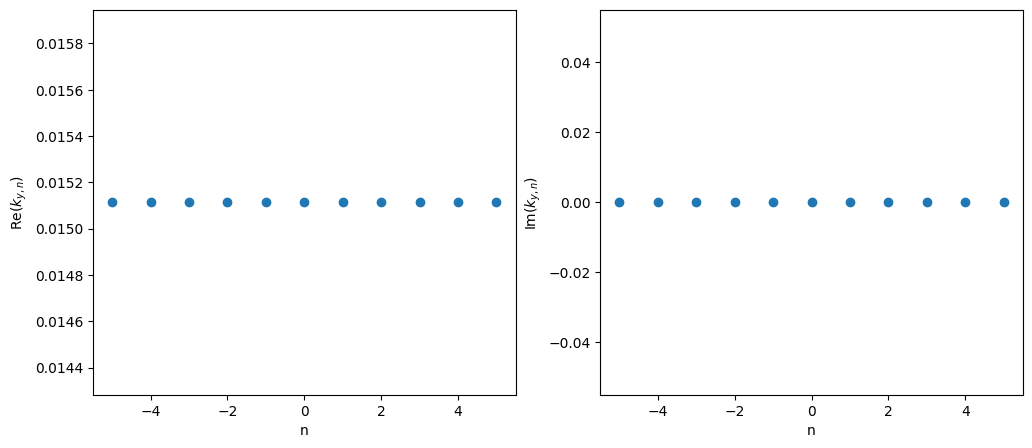

In [49]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(np.arange(-5, 6), np.real(ky_normalized))
plt.xlabel("n")
plt.ylabel(r"Re$(k_{y, n})$")
plt.subplot(122)
plt.scatter(np.arange(-5, 6), np.imag(ky_normalized))
plt.xlabel("n")
plt.ylabel(r"Im$(k_{y, n})$")

Since our grating is only defined in 1D in the x direction, it makes sense for there to be only 1 $k_y$ component.

# Visualizing the S-matrix

| Component of the S-matrix | Meaning |
|---|---|
| `S[0, 0]` | Reflection | 
| `S[1, 0]` | Transmission | 


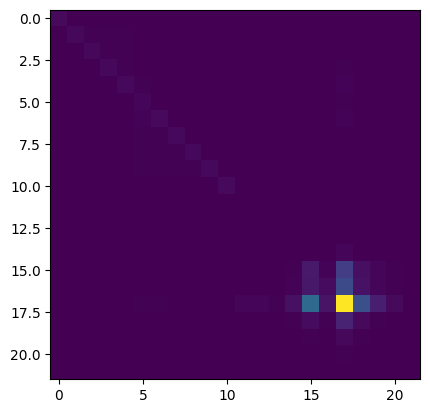

In [50]:
plt.imshow(np.abs(solver_1d.SGlobal[0, 0]))

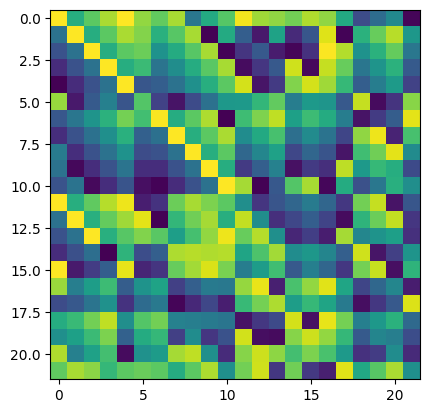

In [51]:
plt.imshow(np.angle(solver_1d.SGlobal[0, 0]))

def s_incident(source, n_harmonics: Union[int, ArrayLike]):
    totalNumberHarmonics = np.prod(n_harmonics)
    return np.hstack((source.pX * kroneckerDeltaVector(totalNumberHarmonics),
            source.pY * kroneckerDeltaVector(totalNumberHarmonics)))


# Angular spectrum decomposition of the reflected waves $A(k_x, k_y)$

In [54]:
reflectedEx, reflectedEy, reflectedEz = solver_1d.reflectedElectricComponents_1D()

/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, '$Phase(E_x)$')

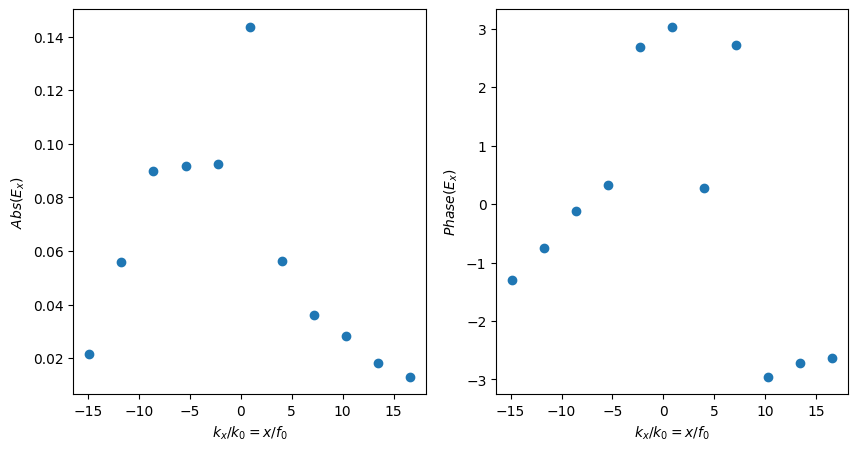

In [55]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(kx_normalized, np.abs(reflectedEx))
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"$Abs(E_x)$")
plt.subplot(122)
plt.scatter(kx_normalized, np.angle(reflectedEx))
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"$Phase(E_x)$")

/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, '$Phase(E_y)$')

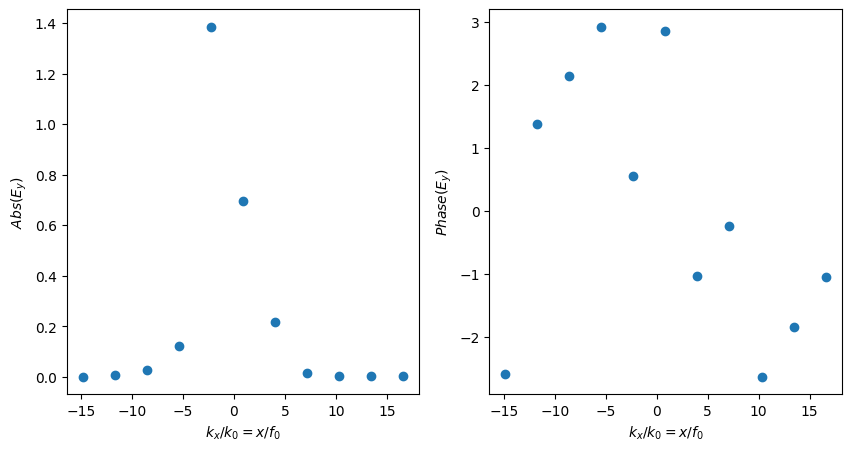

In [56]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(kx_normalized, np.abs(reflectedEy))
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"$Abs(E_y)$")
plt.subplot(122)
plt.scatter(kx_normalized, np.angle(reflectedEy))
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"$Phase(E_y)$")

/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, '$Phase(E_z)$')

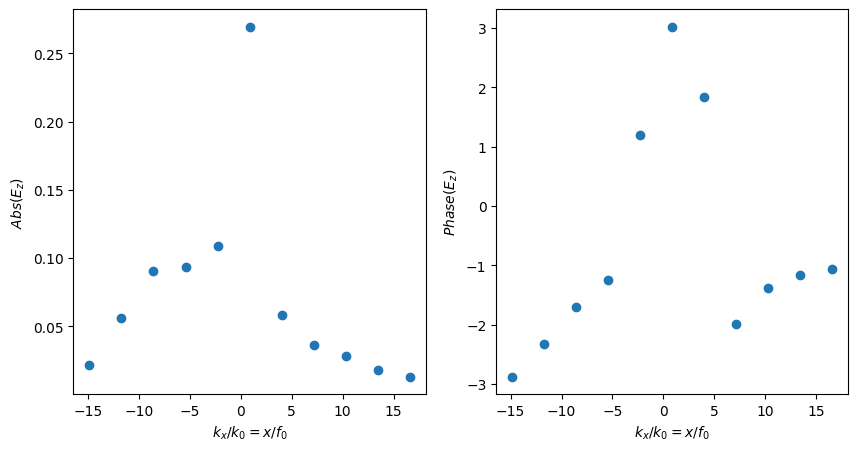

In [57]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(kx_normalized, np.abs(reflectedEz))
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"$Abs(E_z)$")
plt.subplot(122)
plt.scatter(kx_normalized, np.angle(reflectedEz))
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"$Phase(E_z)$")

/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, 'Intensity')

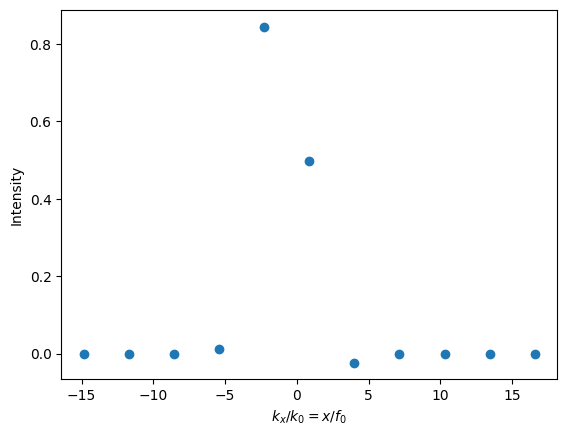

In [73]:
ReflectedHarmonicsIntensity = np.square(reflectedEx) + np.square(reflectedEy) + + np.square(reflectedEz)
plt.scatter(kx_normalized, ReflectedHarmonicsIntensity)
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"Intensity")

/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/yauckwilliam/bluesky/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Calculated by RCWA')

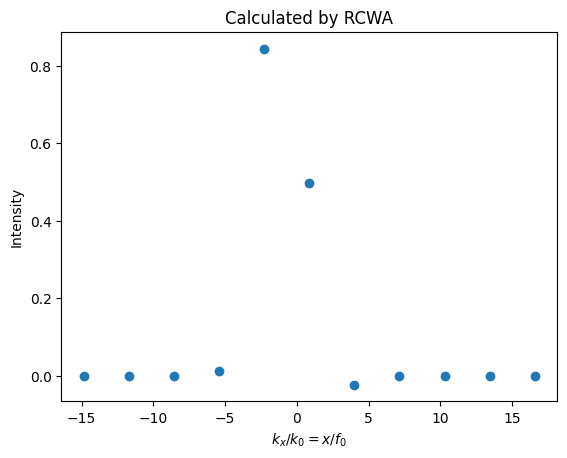

In [61]:
plt.scatter(kx_normalized, np.square(solver_1d.rx) + np.square(solver_1d.ry) + np.square(solver_1d.rz))
plt.xlabel(r"$k_x/k_0 = x/f_0$")
plt.ylabel(r"Intensity")
plt.title("Calculated by RCWA")